In [1]:
from btree import BTree

In [2]:
class KVStore(BTree):
    def __init__(self):
        super().__init__(2)
    
    def __getitem__(self, key):
        return self.get_value(key)
    
    def __setitem__(self, key, value):
        self.add(key, value)
        
    def __contains__(self, key):
        return self.contains(key)
    
    def _range_query(self, range_start, range_end, current_node, min_key, max_key):
        if not self._is_in_bound(range_start, range_end, max_key, min_key):
            return []
        results = []
        for i, key in enumerate(current_node.keys):
            if range_start <= key and key <= range_end:
                results.append(current_node.values[i])
        if not current_node.is_leaf():
            for i, child in enumerate(current_node.children):
                new_min_key = current_node.keys[i - 1] if i > 0 else min_key
                new_max_key = current_node.keys[i] if i < len(current_node) else max_key
                results += self._range_query(range_start, range_end, child, new_min_key, new_max_key)
        return results
    
    def _is_in_bound(self, range_start, range_end, max_key, min_key):
        if not max_key is None and range_start > max_key:
            return False
        if not min_key is None and range_end < min_key:
            return False
        return True
    
    def add(self, key, value):
        node = self._find_node(self.root, key)
        if node is None:
            super().add(key, value)
        else:
            for i, node_key in enumerate(node.keys):
                if key == node_key:
                    node.values[i] = value
    
    def range_query(self, range_start, range_end):
        return self._range_query(range_start, range_end, self.root, None, None)

In [3]:
kv = KVStore()

Testing basic properties and numeric keys

In [4]:
assert kv.split_threshold == 2, "The split is not equal to 2."
kv[1] = 2
assert kv[1] == 2, "Setting item failed to store value."
kv[1] = 4
assert kv[1] == 4, "Changing item value failed."

Testing ```.contains()``` operation

In [6]:
assert 1 in kv, "Contains not working"

In [7]:
kvs = KVStore()
kvs["hello"] = 2
assert "hello" in kvs, "Contains not working for string entries"

Testing ```.range_query()``` for numeric and string keys

In [10]:
kvs["hello"] = 1
kvs["goodbye"] = 10
kvs["farewell"] = 7
kvs["bonjour"] = 4

In [11]:
kvs.range_query("a","z")

[10, 4, 7, 1]

In [12]:
kv2 = KVStore()
kv2[1] = 2
kv2[2] = 8
kv2[3] = 15
kv2[4] = 7
kv2[1000] = 10

In [13]:
kv2.range_query(0,10)

[8, 7, 2, 15]

Compare with queryable KV store based on ```dict```

In [14]:
class DictKVStore(dict):

    def range_query(self, range_start, range_end):
        result = []
        for key in self.keys():
            if range_start <= key and key <= range_end:
                result.append(self[key])
        return result

In [16]:
import random

dict_kv = DictKVStore()
our_kv = KVStore()
for i in range(10):
    dict_kv[i] = i
    our_kv[i] = i

for range_start, range_end in [(random.randint(0,10), random.randint(0,10)+10) for _ in range(10)]:
    dict_res = sorted(dict_kv.range_query(range_start, range_end))
    our_res = sorted(our_kv.range_query(range_start, range_end))
    assert dict_res == our_res, "Both data structures do not return the same range query result."

Test code performance

In [18]:
import time

# set up stores and insert items
kv_test = KVStore()
kv_compare = DictKVStore()
insertion_ratios = []

for i in range(50000):
    start = time.time()
    kv_test[i] = i
    delta1 = time.time() - start
    start = time.time()
    kv_compare[i] = i
    delta2 = time.time() - start
    insertion_ratios.append(delta1 / delta2)

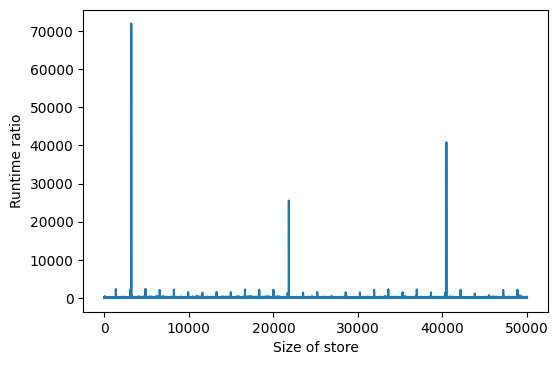

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

# plot insertion time ratios
plt.plot(insertion_ratios)
plt.xlabel('Size of store')
plt.ylabel('Runtime ratio')
plt.show()

In [26]:
import pandas as pd
queries = pd.read_csv('queries.csv')
queries.head()

,range_start,range_end
0,31244,31244
1,43736,43737
2,47449,47451
3,29828,29831
4,29593,29597


In [27]:
# time range queries
query_ratios = []

for _, row in queries.iterrows():
    start = time.time()
    kv_test.range_query(row.range_start, row.range_end)
    runtime1 = time.time() - start
    
    start = time.time()
    kv_compare.range_query(row.range_start, row.range_end)
    runtime2 = time.time() - start
    
    query_ratios.append(runtime1 / runtime2)

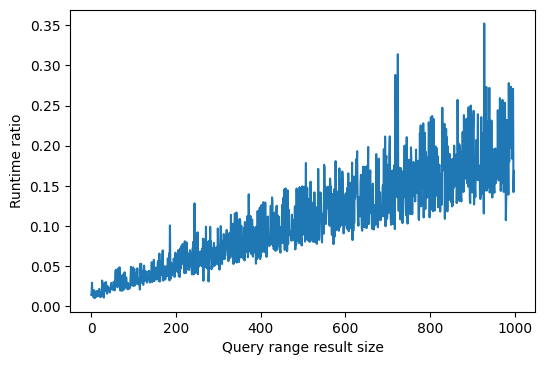

In [28]:
# plot insertion time ratios
plt.plot(query_ratios)
plt.xlabel('Query range result size')
plt.ylabel('Runtime ratio')
plt.show()

It takes much longer to insert values into our KV store (a relatively inexpensive operation anyway), but the dictionary based store is clearly slower to perform range based queries.